# Model architecture

Models are defined in `model.py`.

Actor network consist of 24 input neurons (one for each dimension of state-space), 2 hidden layers 
with variable size controlled by hyperparameters and 2 output neurons (one for each action). 
ReLU activation function is used on each hidden layer and tanh is used on the output layer to ensure 
the output is between -1 and 1 (limitations of the environment).

Critic network consists of 48 input neurons (the global state-space is just the combined local state-spaces of two agents). Critic network consists of 2 hidden layers with variable size controlled by hyperparameters. Input to the second hidden layer is augmented with action vector (size of 4 - 2 agents, 2 actions per agent). The output of critic network is one neuron which returns the Q-value for a given state and actions. ReLU activation funciton is used for all hidden layers.

Initial weights of both networks are filled using uniform distribution.

# Learning algorithm

NOTE: in this Report, when I refer to a Player I mean player defined by the environment that can perform actions and gather local experiences, not the Agent controlling which action is chosen by a Player (the Agent is the same for both Players).

I'm using DDPG algorithm modified to work with multi-agent eviroment. Actor network has only access to the experiences gathered by the particular Player (local state and local actions), whereas the Critic network has access to the experiences gathered by all the Players (global state and global actions). Players' roles do not differ from one another at all (except that one Player is on the left and the other Player on the right side of the tennis court) - they all work for the same goal of keeping the ball up. Therefore, I decided to use only one Agent for both left and right Players.

First, initialize 4 networks: local and target actor networks (with the same weights); local and target critic network (also with the same weights).


## Gather experiences

For each step in the environment and each Player, we get actions (with optionally added random noise) for a given Player's local state using local actor network and act on the environment using the chosen actions. Additionally, we save SARS tuples to the replay buffer. The tuple contains information about both players, e.g. current state constains current local state of left and right Player.

## Learning

Once we have at least the minimum required (batch size) experiences collected, every $t$ steps both local networks are learning from $n$ randomly (uniformly) selected experiences from the replay buffer. During each learning, we update critic and actor networks.

### Local critic network update

For a given experience (current state $s$, current actions $a$, reward $r$, next state $s'$) for both Players we first convert them to global experiences by concatenating local experiences together. Then we predict next actions $a'$ based on $s'$ using target actor network (for each Player). Then, based on concatenated $s'$ and concatenated $a'$, we calculate Q-value $Q'$ using target critic network. Next, compute the $Q^T=r+(\gamma Q')$ (if this is the final experience of an episode then $Q^T=r$), where $\gamma$ is a hyperparameter (discount factor). Lastly, compute expected Q-value $Q$ based on global $a$ and global $s$ using local critic network. Finally, compute the local critic loss $L_{critic}=MSE(Q,Q^T)$ compute the gradient and perform backpropagation for local critic network.

### Local actor network update

For a given experience (as described above) we predict actions $a_p$ for state $s$ for each Player using local actor network. Then calculate expected Q-value $Q$ based on global $s$ and concatenated $a_p$, calculate the local actor loss $L_{actor}=-avg(Q)$. Lastly, calculate gradient and perform backpropagation for local actor network.

### Soft-update target networks

For each weight ($w$) in actor and critict networks:
$$
w_{target}=w_{local}\bullet \tau + (1 - \tau)\bullet w_{target}
$$
where $\tau$ is a hyperparameter specifying how much the target network's weights should be updated. $\tau=0$ means no update; $\tau=1$ means that target network equals local network.

## Flowchart of learning

The flowchart below illustrates the learning algorithm described above. LA, TA, LC and TC mean respectively: local actor network, target actor network, local critic network and target critic network.

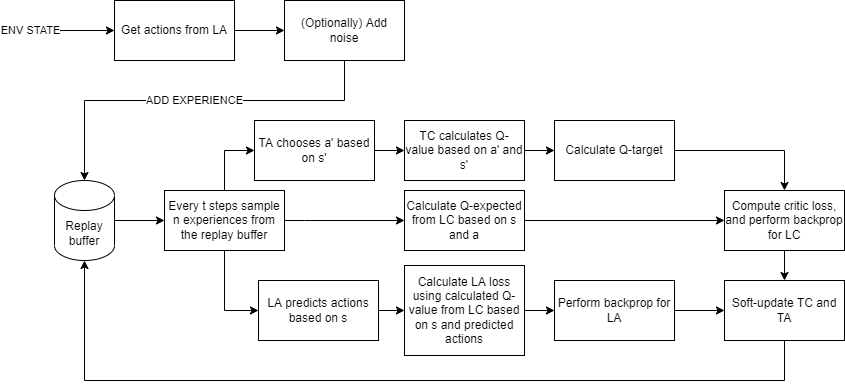

# Training

Most of the code is reused from the previous project - Continuous Control - and some hyperparameters, like $\gamma$ (discount factor), $\tau$ (update factor for soft-update), weight decay (for actor network), buffer size, batch size, $t$ (how often should learning "session" happen) and $n$ (how many times we should learn during learning "session") remained unchanged.

To add variation to actions' values I use normal noise.

## Learning rate and hidden layer sizes tweaking

At the beginning, I decided to focus on optimising learning rate and hidden layer size of each network. The performance I got was quite good but not enought to solve the environment.

Below you can see the rolling average (100 episodes) of some training runs and the chosen hyperparameters.

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import json


def plot_scores(vers, title):
    legend = []
    score_len = 0
    for v in vers:
        folder = f"training/run{v}"
        df = pd.read_csv(f"{folder}/scores.csv")
        mean_scores = df.mean(axis=1)
        score_len = max(len(mean_scores), score_len)
        mean_scores.rolling(100).mean().plot()
        
        with open(f"{folder}/checkpoint.json", "rb") as json_file:
            params = json.load(json_file)
        
        legend.append(v)
        
        print("-----------")
        print("Version:", v)
        print("learning rate actor:", params["ddpg"]["lr_actor"])
        print("learning rate critic:", params["ddpg"]["lr_critic"])
        print("hidden layer 1 actor:", params["ddpg"]["actor_l1"])
        print("hidden layer 2 actor:", params["ddpg"]["actor_l2"])
        print("hidden layer 1 critic:", params["ddpg"]["critic_l1"])
        print("hidden layer 2 critic:", params["ddpg"]["critic_l2"])
        
    plt.plot([0, score_len], [0.5, 0.5], 'r--')
    plt.xlim(0, score_len)
    plt.legend(legend)
    plt.title(title)
    plt.ylabel('Score')
    plt.xlabel('Episode #')

-----------
Version: v2.2
learning rate actor: 0.001
learning rate critic: 0.001
hidden layer 1 actor: 300
hidden layer 2 actor: 200
hidden layer 1 critic: 400
hidden layer 2 critic: 200
-----------
Version: v2.4
learning rate actor: 0.0001
learning rate critic: 0.0003
hidden layer 1 actor: 200
hidden layer 2 actor: 80
hidden layer 1 critic: 300
hidden layer 2 critic: 140
-----------
Version: v2.5
learning rate actor: 0.001
learning rate critic: 0.001
hidden layer 1 actor: 100
hidden layer 2 actor: 40
hidden layer 1 critic: 150
hidden layer 2 critic: 70
-----------
Version: v2.7
learning rate actor: 0.0001
learning rate critic: 0.0003
hidden layer 1 actor: 300
hidden layer 2 actor: 150
hidden layer 1 critic: 400
hidden layer 2 critic: 200
-----------
Version: v2.8
learning rate actor: 0.0001
learning rate critic: 0.0003
hidden layer 1 actor: 300
hidden layer 2 actor: 150
hidden layer 1 critic: 400
hidden layer 2 critic: 200
-----------
Version: v2.9
learning rate actor: 0.0001
learning

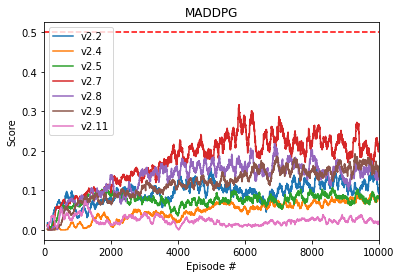

In [10]:
versions = [f"v2.{i}" for i in [2, 4, 5, 7, 8, 9, 11]]
plot_scores(
    versions, 
    "MADDPG"
)

We can clearly see that v2.7 performs the best of the bunch but it is still far from solving the environment. However, when I ran it to see how it performs live it turned out to peform much better than the plot above would suggest. See the results before.

In [11]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="Tennis_Windows_x86_64/Tennis.exe")
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


In [12]:
import json
from maddpg import MultiAgent
from ddpg_agent import DDPGAgent
import torch

def create_agent(params):
    ddpg = DDPGAgent(
        state_size=24,
        full_state_size=24*2,
        action_size=2,
        full_action_size=2*2,
        **params["ddpg"],
    )
    ddpg.noise_scalar = 0.00000001
    return MultiAgent(
        agents=[ddpg, ddpg],
        **params["multi_agent"],
    )

def test(agent):
    env_info = env.reset(train_mode=True)[brain_name]
    num_agents = len(env_info.agents)
    states = env_info.vector_observations
    scores = np.zeros(num_agents)
    dones = np.array([False for _ in range(num_agents)])
    for _ in range(1000):
        actions = agent.act(states, add_noise=True)
        env_info = env.step(actions.astype(np.int32))[brain_name]        # send the action to the environment
        states = env_info.vector_observations   # get the next state
        rewards = env_info.rewards                   # get the reward
        dones = env_info.local_done                  # see if episode has finished
        scores += rewards
        if np.any(dones):
            break
    return np.max(scores)

def run_tests(ver, n):
    folder = f"training/run{ver}"
    with open(f"{folder}/checkpoint.json", "rb") as file:
        params = json.load(file)
    print(params)
    agent = create_agent(params)
    agent.agents[0].actor_local.load_state_dict(torch.load(f'training/run{ver}/checkpoint_actor.pth'))
    
    scores = []
    for i in range(n):
        scores.append(test(agent))
        
    return scores

{'ddpg': {'lr_actor': 0.0001, 'lr_critic': 0.0003, 'actor_l1': 300, 'actor_l2': 150, 'critic_l1': 400, 'critic_l2': 200, 'noise_scalar': 0.25}, 'multi_agent': {'learn_every_t_steps': 10, 'learn_n_times': 20}}
Average test score over 100 episodes: 1.9500000290572643


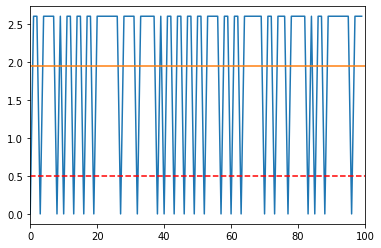

In [14]:
scores = run_tests("v2.7", 100)
mean_score = np.array(scores).mean()
print(f"Average test score over 100 episodes: {mean_score}")
plt.plot(scores)
plt.plot([0, 100], [mean_score]*2)
plt.plot([0, 100], [0.5, 0.5], 'r--')
plt.xlim(0, 100)
plt.show()

As we can see it performs way above the solving threshold. It turned out be the issue with noise. I kept the noise scalar constant at 0.25 which introduced random variations to the actions taken by the agent which lowered the performance.

## Tweaking noise

Based on these findings, I decided to introduce another hyperparameter - weight decay - which is responsible for reducing the random noise over time. Unfortunately this didn't improve performance.

In [18]:
import matplotlib.pyplot as plt
import pandas as pd
import json


def plot_scores(vers, title):
    legend = []
    score_len = 0
    for v in vers:
        folder = f"training/run{v}"
        df = pd.read_csv(f"{folder}/scores.csv")
        mean_scores = df.mean(axis=1)
        score_len = max(len(mean_scores), score_len)
        mean_scores.rolling(100).mean().plot()
        
        with open(f"{folder}/checkpoint.json", "rb") as json_file:
            params = json.load(json_file)
        
        legend.append(v)
        
        print("-----------")
        print("Version:", v)
        print("learning rate actor:", params["ddpg"]["lr_actor"])
        print("learning rate critic:", params["ddpg"]["lr_critic"])
        print("hidden layer 1 actor:", params["ddpg"]["actor_l1"])
        print("hidden layer 2 actor:", params["ddpg"]["actor_l2"])
        print("hidden layer 1 critic:", params["ddpg"]["critic_l1"])
        print("hidden layer 2 critic:", params["ddpg"]["critic_l2"])
        print("noise scalar:", params["ddpg"]["noise_scalar"])
        print("noise decay:", params["ddpg"].get("noise_decay", 1))
        
    plt.plot([0, score_len], [0.5, 0.5], 'r--')
    plt.xlim(0, score_len)
    plt.legend(legend)
    plt.title(title)
    plt.ylabel('Score')
    plt.xlabel('Episode #')

-----------
Version: v4.0
learning rate actor: 0.0001
learning rate critic: 0.0003
hidden layer 1 actor: 300
hidden layer 2 actor: 150
hidden layer 1 critic: 400
hidden layer 2 critic: 200
noise scalar: 0.25
noise decay: 0.9999
-----------
Version: v4.1
learning rate actor: 0.0001
learning rate critic: 0.0003
hidden layer 1 actor: 300
hidden layer 2 actor: 150
hidden layer 1 critic: 400
hidden layer 2 critic: 200
noise scalar: 0
noise decay: 1


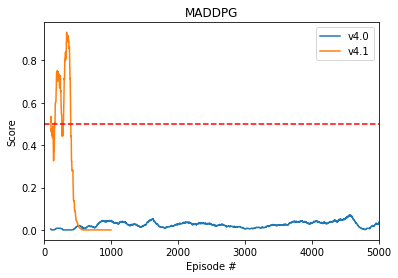

In [19]:
versions = [f"v4.{i}" for i in [0, 1]]
plot_scores(
    versions, 
    "MADDPG"
)

For v4.0 I decided to train the agent v2.7 with no noise which didn't turn out well.

The agent was clearly learning despite the big noise. It was learning better with big noise than small or no noise so I came up with idea to test the agent's performance without the noise but normally train it with noise on. The performance turned out to be spectacular.

For the final agent I tried in two intervals, each 6000 episodes. I was saving the model only when the current average test score was the highest. The training scores don't look that promissing but the test performance is almost perfect. The perfect agent can get the maximum score of 2.6, this agent got 2.5 on average over 100 episodes! It solved the environment around episode 7500.

In [22]:
import matplotlib.pyplot as plt

def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n-1:] / n
    
def overlay_moving_average(title, score, n):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    avg = moving_average(score, n)
    plt.plot(np.arange(len(score)), score)
    plt.plot(np.arange(len(avg)) + n, avg)
    # plt.plot([0, len(score)], [30, 30], 'r--')
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.xlim(0, len(score))
    plt.title(title)
    plt.show()

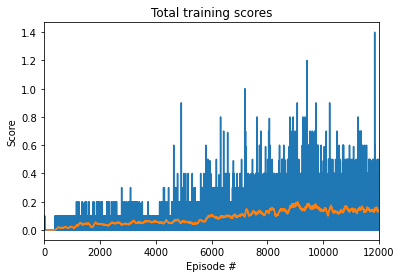

In [23]:
import pandas as pd

df1 = pd.read_csv(f"training/runv5.0/scores.csv")
df2 = pd.read_csv(f"training/runv5.5/scores.csv")
total_scores = np.concatenate([df1.mean(axis=1).to_numpy(), df2.mean(axis=1).to_numpy()])
overlay_moving_average("Total training scores", total_scores, 100)

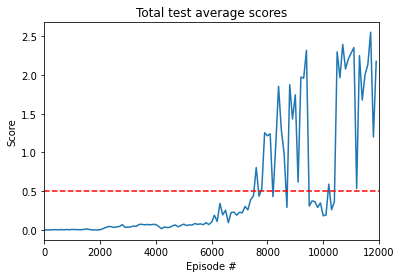

In [24]:
with open(f"training/runv5.0/test_scores.json", "rb") as file:
    previous_test_scores = json.load(file)

mean_previous_test_scores = [np.array(test_results).mean() for test_results in previous_test_scores]

with open(f"training/runv5.5/test_scores.json", "rb") as file:
    next_test_scores = json.load(file)

mean_next_test_scores = [np.array(test_results).mean() for test_results in next_test_scores]

plt.plot(np.arange(0, len(total_scores), 100), mean_previous_test_scores + mean_next_test_scores)
plt.xlabel("Episode #")
plt.ylabel("Score")
plt.xlim(0, len(total_scores))
plt.title("Total test average scores")
plt.plot([0, len(total_scores)], [0.5, 0.5], 'r--')
plt.show()

See the live performance of this agent below:

{'ddpg': {'lr_actor': 0.0001, 'lr_critic': 0.0003, 'actor_l1': 300, 'actor_l2': 150, 'critic_l1': 400, 'critic_l2': 200, 'noise_scalar': 0.25, 'noise_decay': 1}, 'multi_agent': {'learn_every_t_steps': 10, 'learn_n_times': 20}}
Average test score over 100 episodes: 2.5039000373147426


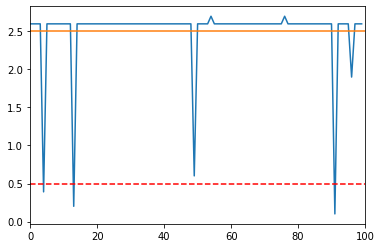

In [25]:
scores = run_tests("v5.5", 100)
mean_score = np.array(scores).mean()
print(f"Average test score over 100 episodes: {mean_score}")
plt.plot(scores)
plt.plot([0, 100], [mean_score]*2)
plt.plot([0, 100], [0.5, 0.5], 'r--')
plt.xlim(0, 100)
plt.show()

In [26]:
env.close()

# Final thoughts and future work

The most importan realisation during the training was the impact noise makes on the performance of an agent. The final agent is almost perfect performer!

For future work, I could definitely experiment with other types of noise, especially Adaptive Parameter Noise. Also, I could implement Prioritized Experience Replay.